# Проект 5. Компьютер говорит "нет"
## Имя: Макаров Василий
#### Ник в каггле Evil_pie27

Задача: Предсказать вероятность дефолта клиента банка

Цель: По данным из датасета, содержащего информацию о банковских клиентах, построить модель, предсказывающую, совершит ли данный заемщик дефолт, для того, чтобы банк мог принимать решение о выдаче кредита данному заемщику. В качестве метрики использовать кривую ROC AUC.

# загрузка библиотек и исходных данных данных

In [1]:
# Импортируем библиотеки
import pandas as pd
from pandas import Series
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score

import warnings
warnings.filterwarnings('ignore')

#import pandas_profiling

In [2]:
# Используемые функции
def num_column_curves(colunm_name, sourse):
    """Функция визуализации данных числовых признаков"""

    sns.boxplot(x='default', y=colunm_name, data=sourse)  # строим boxplot
    plt.show()

    data[colunm_name].hist(bins=20)  # строим гистограмму

In [3]:
# Загружаем исходные данные
train = pd.read_csv("./train.csv", encoding='ISO-8859-1', low_memory=False)
test = pd.read_csv("./test.csv", encoding='ISO-8859-1', low_memory=False)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

## Описание полей
  * client_id - идентификатор клиента
  * education - уровень образования
  * sex - пол заемщика
  * age - возраст заемщика
  * car - флаг наличия автомобиля
  * car_type - флаг автомобиля иномарки
  * decline_app_cnt - количество отказанных прошлых заявок
  * good_work - флаг наличия “хорошей” работы
  * bki_request_cnt - количество запросов в БКИ
  * home_address - категоризатор домашнего адреса
  * work_address - категоризатор рабочего адреса
  * income - доход заемщика
  * foreign_passport - наличие загранпаспорта
  * sna - связь заемщика с клиентами банка
  * first_time - давность наличия информации о заемщике
  * score_bki - скоринговый балл по данным из БКИ
  * region_rating - рейтинг региона
  * app_date - дата подачи заявки
  * default - флаг дефолта по кредиту

Для начала посмотрим распределение целевого признака default

<AxesSubplot:xlabel='default', ylabel='count'>

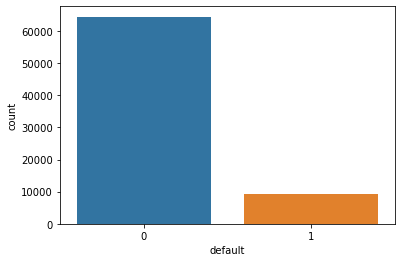

In [6]:
sns.countplot(x='default', data=train)
# Больше всего клиентов без дефолта, то есть распределение несбалансированное

Необходимо объединить данные в один датасет, так как в файле test нет данных о дефолте клиента, то предварительно заполним их нулями. Также необходимо отметить какие данные отсятся к train(1) и test(0)

In [7]:
test['default'] = 0  # заполняем целевой признак нулями
test['train'] = 0  # отмечаем 0 записи которые относятся к test
train['train'] = 1  # отмечает 1 записи которые относятся к train

data = pd.concat([train, test.reindex(
    columns=train.columns)], ignore_index=True)


data.sample(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
68169,10923,18JAN2014,SCH,M,28,Y,Y,1,0,-1.454993,3,70,2,3,40000,2,3,N,0,1
23923,105359,24APR2014,SCH,F,58,N,N,0,0,-1.600528,0,80,2,3,12700,4,1,N,0,1
22655,36942,13FEB2014,SCH,F,51,N,N,1,0,-1.817752,3,50,1,2,25000,1,4,N,0,1
109354,56991,05MAR2014,UGR,M,21,N,N,0,0,-1.240206,0,70,1,3,40000,1,2,N,0,0
38229,17037,24JAN2014,GRD,F,53,Y,Y,0,0,-1.298594,0,70,1,2,100000,1,4,N,0,1
82424,47066,24FEB2014,GRD,M,30,N,N,2,0,-2.080334,5,50,2,3,28000,3,1,N,0,0
31282,63136,12MAR2014,UGR,M,34,Y,Y,0,0,-1.875781,2,80,2,3,200000,1,4,Y,0,1
20423,24008,31JAN2014,GRD,F,54,N,N,0,0,-2.022912,2,50,1,1,55000,1,4,N,0,1
53961,19193,26JAN2014,SCH,M,51,Y,N,0,0,-1.847175,2,50,1,2,80000,2,1,N,0,1
53147,43168,19FEB2014,SCH,F,54,Y,N,0,0,-1.466834,1,80,2,3,51000,1,4,N,0,1


# Проведение EDA анализа в pandas-profiling

In [8]:
#pandas_profiling.ProfileReport(data)

Пропуски наблюдаются только у признака education.
Целевая переменная не сбалансированна - количество дефолтных клиентов сильно меньше количества недефолтных клиентов.
По тепловы картам наблюдается корреляция у признаков first_time и sna, work_address и home_address

# Первичный осмотр данных
### Пропуски

In [9]:
data.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
train                 0
dtype: int64

Пропуски наблюдаются только у признака education. Потому рассмотрим данные подробнее

In [10]:
print(data['education'].value_counts(normalize=True))

print('Процент пропусков: ', round(
    data['education'].isna().sum() / len(data['education']) * 100, 2), '%')

SCH    0.528841
GRD    0.317024
UGR    0.134476
PGR    0.017006
ACD    0.002653
Name: education, dtype: float64
Процент пропусков:  0.43 %


<AxesSubplot:>

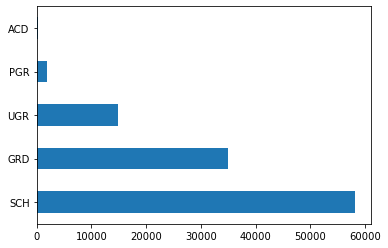

In [11]:
# Заполним пропуски рандомно, в соответствии с распределением имеющихся данных
data.fillna('ran', inplace=True)
data['education'] = data['education'].apply(lambda x: np.random.choice(['SCH', 'GRD', 'UGR', 'PGR', 'ACD'],
                                                                       p=[0.529, 0.317, 0.134, 0.017, 0.003])
                                            if x == 'ran' else x)
data['education'].value_counts().plot.barh()

###  Признак app_date
Так как в этом признаке указана дата подачи заявки, то ее необходимо извлечь в правильном формате и создать новые признаки, связанные с датой

In [12]:
# Переводит все данные в формат datetime
data.app_date = pd.to_datetime(data.app_date)

In [13]:
# Проверим за какие года предоставлены данные
data.app_date.dt.year.unique()

array([2014], dtype=int64)

In [14]:
# Создадим новые признаки с днем месяца, месяцем и днем недели
data['app_day'] = data.app_date.dt.day
data['app_mon'] = data.app_date.dt.month
data['app_weekday'] = data.app_date.dt.weekday

### Списки признаков

In [15]:
# Создаем списки числовых, бинарных и категориальных переменных:
# Признак app_date пока выкидываем

# числовые
num_cols = [
    'age',
    'decline_app_cnt',
    'score_bki',
    'bki_request_cnt',
    'income'
]

# бинарные
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

# категориальные
cat_cols = [
    'education',
    'region_rating',
    'home_address',
    'work_address',
    'sna',
    'first_time',
    'app_day',
    'app_mon',
    'app_weekday'
]

# Визуализация

### Числовые признаки

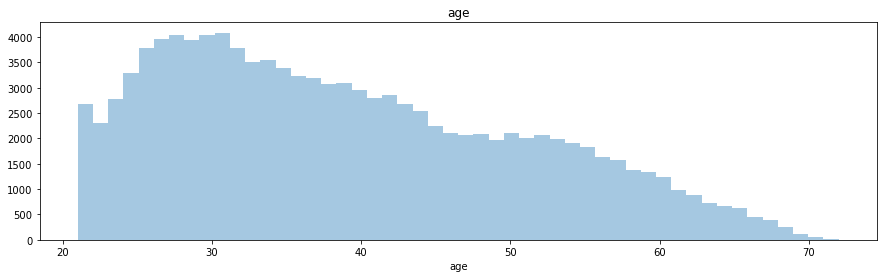

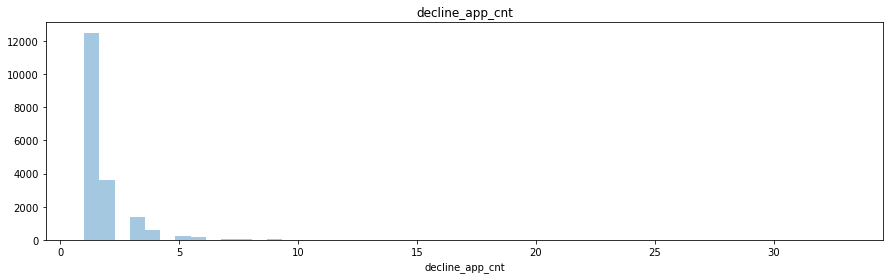

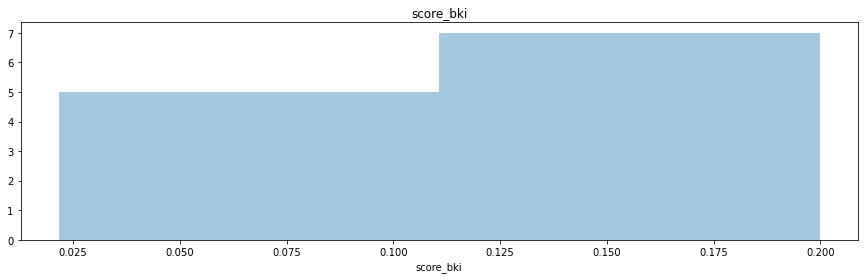

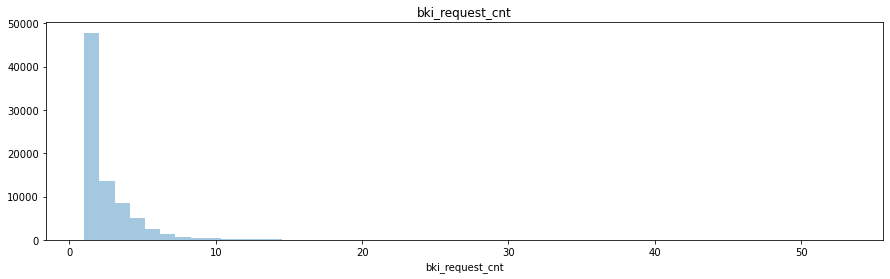

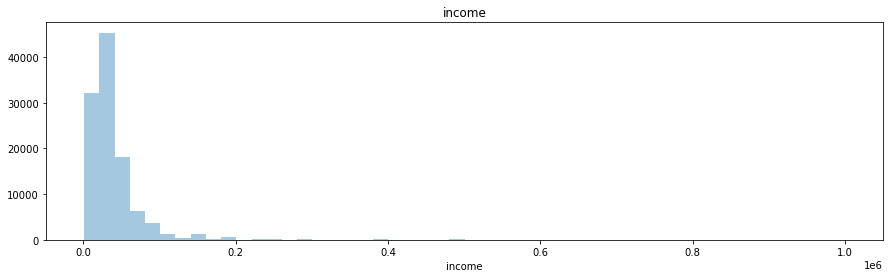

In [16]:
# Построим графики распределения числовых переменных
for i in num_cols:
    plt.figure(figsize=(15, 4))
    sns.distplot(data[i][data[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

Большинство распределений смещены влево.

Посмотрим на бокс плоты по числовым переменным

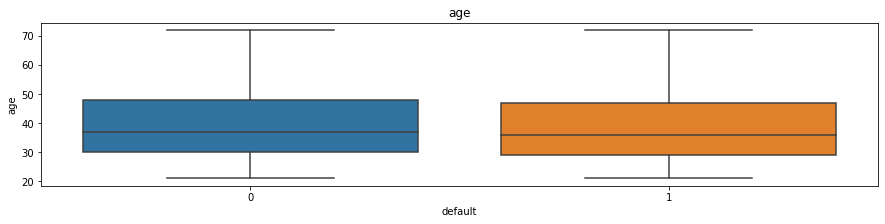

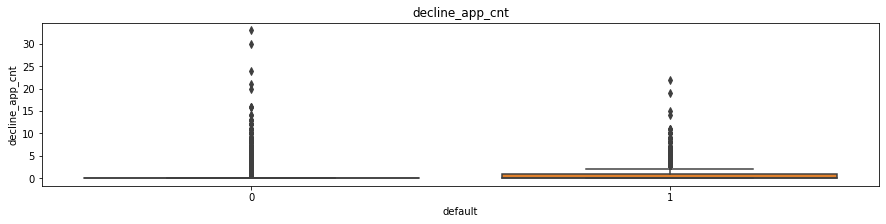

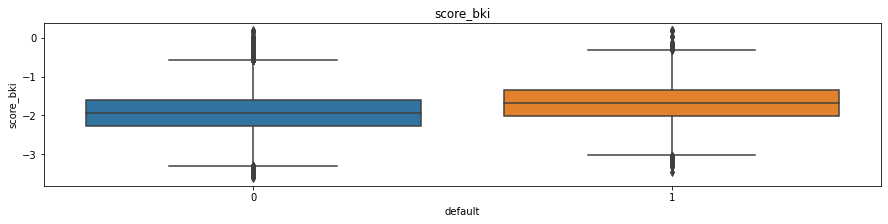

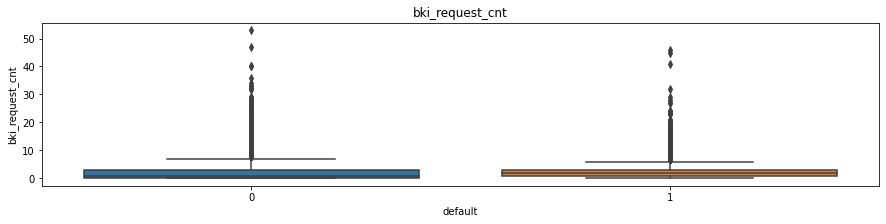

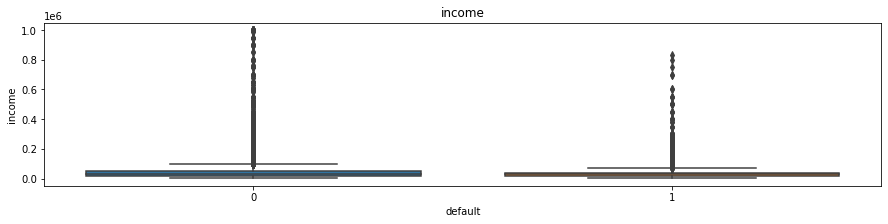

In [17]:
for i in num_cols:
    plt.figure(figsize=(15, 3))
    sns.boxplot(x='default', y=data[i], data=data,
                meanline=True)
    plt.title(i)
    plt.show()

В среднем дефолтные клиенты моложе, средний скоринговый балл выше, очевидно по ним больше запросов в БКИ.

Посмотрим на тепловую карту и проверим корреляцию

<AxesSubplot:>

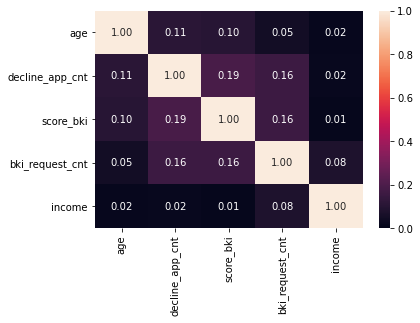

In [18]:
# Оценим корреляцию Пирсона для непрерывных переменных
train_num = pd.DataFrame(data=data, columns=num_cols)
sns.heatmap(train_num.corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f")

Наблюдается коррекляция между парами признаков - 'score_bki' и 'decline_app_cnt'; 'bki_request_cnt' и 'decline_app_cnt'; 'bki_request_cnt' и 'score_bki'

Проверим значимость непрерывных переменных

<AxesSubplot:>

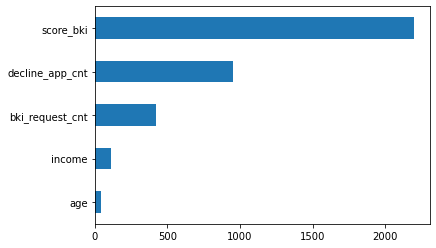

In [19]:
# Построим график значимости числовых переменных
imp_num = pd.Series(f_classif(
    data[num_cols], data['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Так как признаки 'score_bki', 'decline_app_cnt', 'bki_request_cnt' имеют важное значение то на данном этапе принято решение использовать эти признаки в модели.
Далее рассмотрим каждый признак по отдельности, прологарифмируем требующие этого признаки и выявим выбросы.

In [20]:
# удаляем признак app_day
num_cols = [
    'age',
    'decline_app_cnt',
    'score_bki',
    'bki_request_cnt',
    'income'
]

#### Age

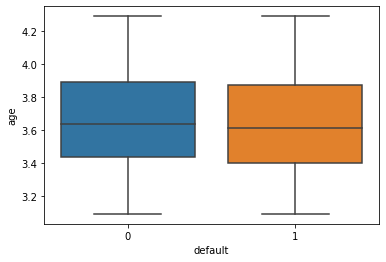

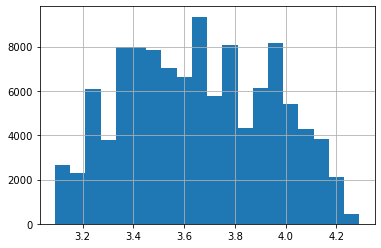

In [21]:
# Прологарифмируем признак, так как его график распределения смещен влево и посмотрим его боксплот
data['age'] = data['age'].apply(lambda w: np.log(w + 1))
num_column_curves('age', data)

Распределение удалось привести к нормальному, выбросов не наблюдается

#### decline_app_cnt

In [22]:
# Посмотрим наиболее частые значения
data['decline_app_cnt'].value_counts(sort=True, ascending=False)

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
15        1
19        1
20        1
21        1
22        1
24        1
30        1
33        1
Name: decline_app_cnt, dtype: int64

Более 80% данных приходится на первые 3-4 значения, осталные встречаются единично. Есть смысл перевести этот признак из категории числовых в категорию переменных

In [23]:
# Заменим значения
data.decline_app_cnt = data.decline_app_cnt.apply(
    lambda x: (x if x < 4 else 4))

# Переведем признак из числовых и в категориальные
num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')

# Проверим правильность проведения распределения
data['decline_app_cnt'].value_counts(sort=True, ascending=False)

0    91471
1    12500
2     3622
3     1365
4     1190
Name: decline_app_cnt, dtype: int64

#### score_bki

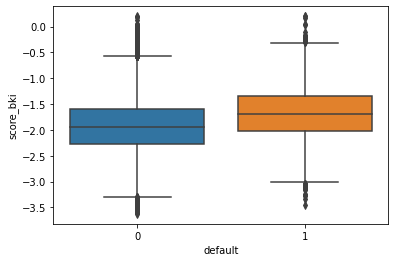

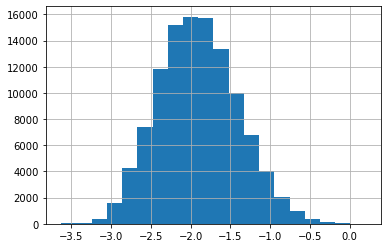

In [24]:
# Посмотрим распределение признака
num_column_curves('score_bki', data)

Распределение признака выглядит нормальным.

#### bki_request_cnt

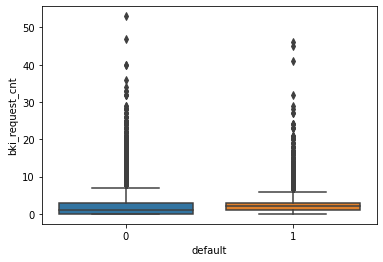

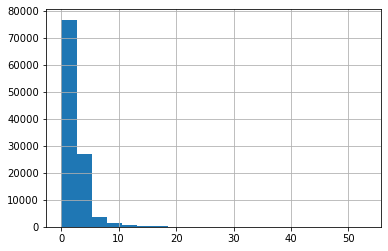

In [25]:
# Посмотрим распределение признака
num_column_curves('bki_request_cnt', data)

In [26]:
# Посмотрим наиболее частые значения
data['bki_request_cnt'].value_counts(sort=True, ascending=False)

0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
24       12
23       12
22        8
25        5
27        5
28        5
26        4
32        4
29        3
40        2
33        2
36        1
34        1
41        1
45        1
46        1
47        1
53        1
Name: bki_request_cnt, dtype: int64

Большинство данных приходится на первые 7 значений, осталные встречаются единично, потому данные , значение которых больше 7 объединим в одну группу и переведем этот признак из категории числовых в категорию переменных

In [27]:
# Заменим значения
data['bki_request_cnt'] = data['bki_request_cnt'].apply(
    lambda x: (x if x < 7 else 7))

# Переведем признак из числовых и в категориальные
num_cols.remove('bki_request_cnt')
cat_cols.append('bki_request_cnt')

Так как график смещен влево попробует прологарифмировать признак и посмотрим на изменение распределения

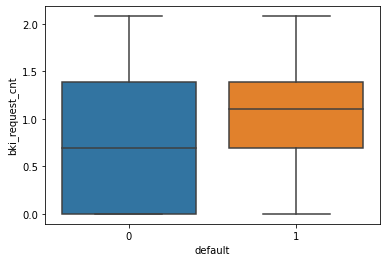

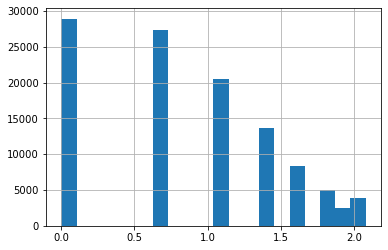

In [28]:
data['bki_request_cnt'] = data['bki_request_cnt'].apply(
    lambda w: np.log(w + 1))
num_column_curves('bki_request_cnt', data)

Логарифмированное распределение признака выглядит более нормальным

#### income

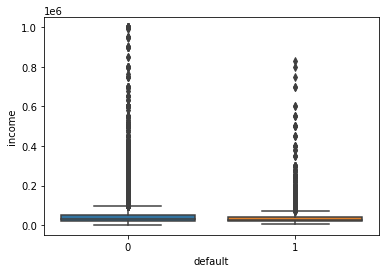

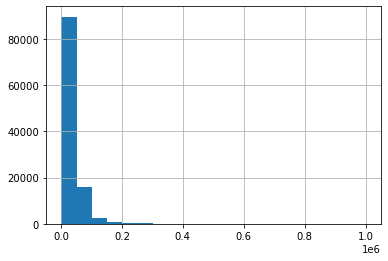

In [29]:
# Посмотрим распределение признака
num_column_curves('income', data)

Так как график смещен влево попробует прологарифмировать признак и посмотрим на изменение распределения

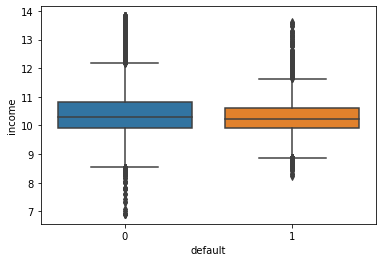

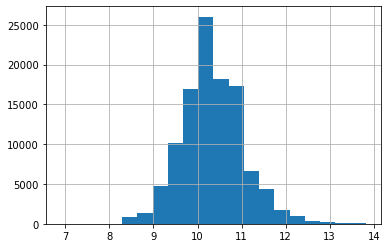

In [30]:
data['income'] = data['income'].apply(lambda w: np.log(w + 1))
num_column_curves('income', data)

Логарифмированное распределение признака выглядит более нормальным

In [31]:
# посчитаем выбросы для числовых признаков
for col in num_cols:
    print('Числовой признак "{a}":'.format(a=col))  # выводим название признака
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    left = Q1 - 1.5*IQR
    right = Q3 + 1.5*IQR
    print('Количество выбросов: ', data[col][(
        data[col] < left) | (data[col] > right)].count())
    print('\n')

Числовой признак "age":
Количество выбросов:  0


Числовой признак "score_bki":
Количество выбросов:  518


Числовой признак "income":
Количество выбросов:  2609




Выявленные выбросы могут таковыми и не являться, так как Исполнителю не хватает практического опыта и полного понимания смысла всех признако, то примем допущение что по физическому смыслу признаки могут принимать значения, которые методом межквартильного растояни были выявлены как выбросы, потому удалять выбросы из датасета не будем.

### Бинарные признаки

In [32]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# убедимся в преобразовании
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,default,train,app_day,app_mon,app_weekday
0,25905,2014-02-01,SCH,1,4.143135,1,1,0,0,-2.008753,...,2,9.798183,4,1,0,0,1,1,2,5
1,63161,2014-03-12,SCH,0,4.094345,0,0,0,0,-1.532276,...,3,9.852247,4,1,0,0,1,12,3,2
2,25887,2014-02-01,SCH,1,3.258097,1,0,2,0,-1.408142,...,2,10.308986,1,4,1,0,1,1,2,5
3,16222,2014-01-23,SCH,0,3.988984,0,0,0,0,-2.057471,...,3,9.210440,1,3,0,0,1,23,1,3
4,101655,2014-04-18,GRD,1,3.891820,0,0,0,1,-1.244723,...,3,10.308986,1,4,1,0,1,18,4,4


Признак "sex":
0    41562
1    32237
Name: sex, dtype: int64


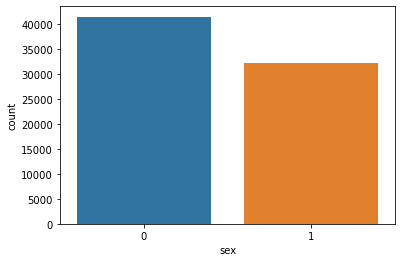

Признак "car":
0    49832
1    23967
Name: car, dtype: int64


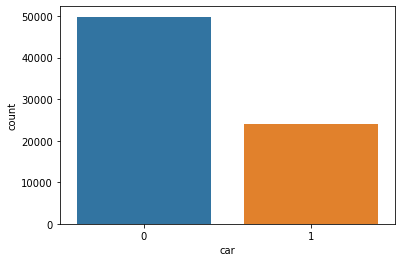

Признак "car_type":
0    59791
1    14008
Name: car_type, dtype: int64


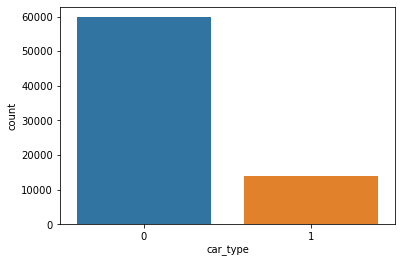

Признак "good_work":
0    61630
1    12169
Name: good_work, dtype: int64


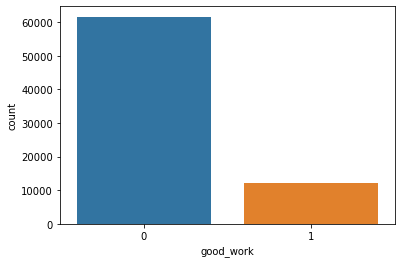

Признак "foreign_passport":
0    62733
1    11066
Name: foreign_passport, dtype: int64


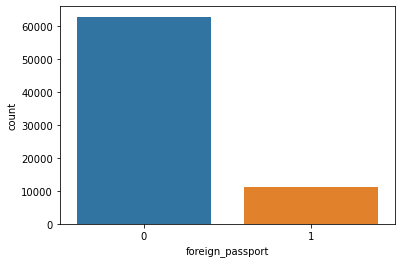

In [33]:
# рассматрим распределение бинарных признаков
for col in bin_cols:
    print('Признак "{a}":'.format(a=col))  # выводим название признака

    # выводим уникальные значения и их количество
    print(data[col][data['train'] == 1].value_counts())

    # выводим распределение заемщиков по признакам
    plt.figure()
    sns.countplot(x=col, data=data[data['train'] == 1])
    plt.show()

Как видно из графиков - во всех бинарных признаках наблюдается несбалансированное распределение - один показатель преобладает над другим, кроме признака sex, где различие не такое большое.

### Категориальные признаки

Признак "education":
SCH    39018
GRD    23467
UGR     9859
PGR     1261
ACD      194
Name: education, dtype: int64


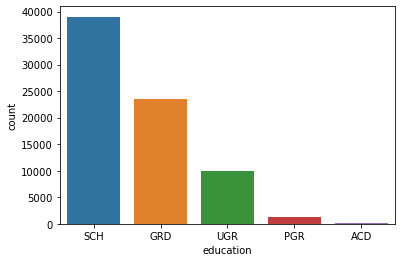

Признак "region_rating":
50    27523
60    16075
40    12027
80    11469
70     6199
30      300
20      206
Name: region_rating, dtype: int64


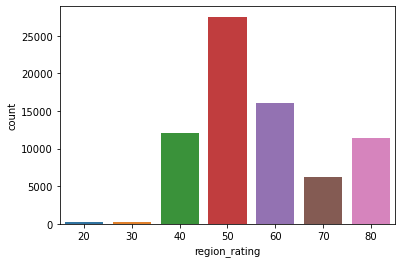

Признак "home_address":
2    39956
1    32585
3     1258
Name: home_address, dtype: int64


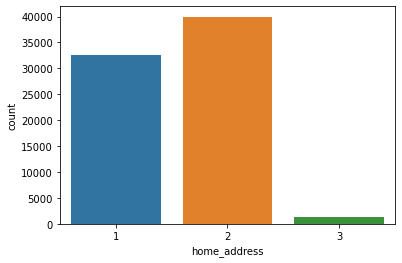

Признак "work_address":
3    44959
2    20506
1     8334
Name: work_address, dtype: int64


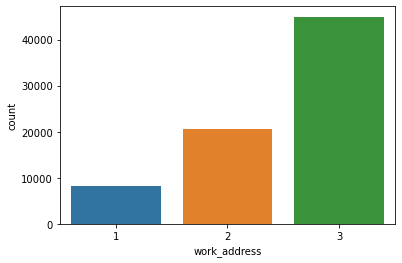

Признак "sna":
1    47301
4    11749
2    10626
3     4123
Name: sna, dtype: int64


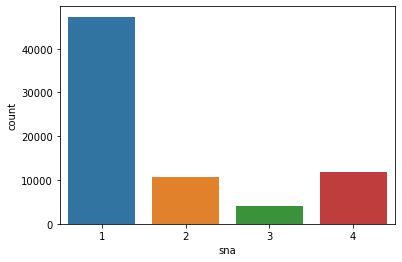

Признак "first_time":
3    31255
4    18737
1    12239
2    11568
Name: first_time, dtype: int64


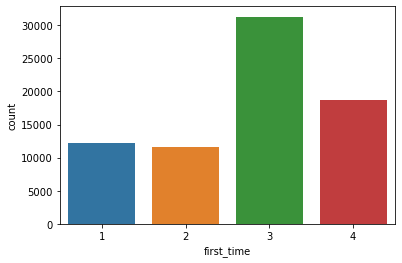

Признак "app_day":
17    3025
28    2949
18    2884
21    2868
11    2750
24    2727
15    2634
14    2605
10    2584
27    2579
4     2557
20    2534
3     2529
22    2499
7     2470
19    2449
5     2425
12    2402
25    2358
13    2302
6     2280
16    2274
9     2160
26    2076
1     1962
23    1944
30    1864
8     1831
2     1826
29    1740
31    1712
Name: app_day, dtype: int64


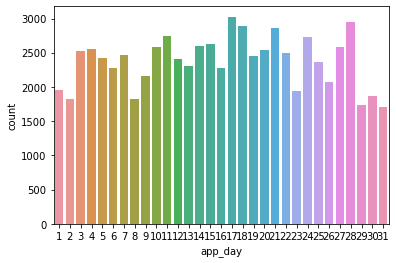

Признак "app_mon":
3    21178
2    18028
4    17683
1    16910
Name: app_mon, dtype: int64


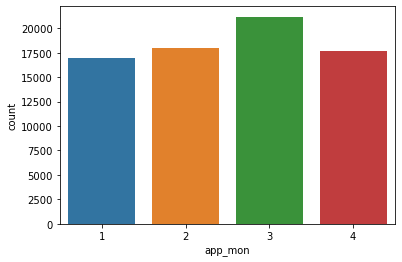

Признак "app_weekday":
1    12176
0    12024
2    11740
3    11615
4    11263
5     8231
6     6750
Name: app_weekday, dtype: int64


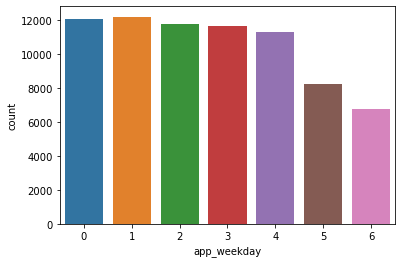

Признак "decline_app_cnt":
0    61214
1     8397
2     2468
3      903
4      817
Name: decline_app_cnt, dtype: int64


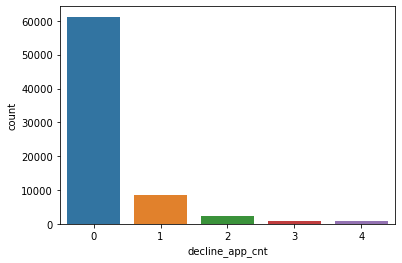

Признак "bki_request_cnt":
0.000000    19381
0.693147    18276
1.098612    13749
1.386294     9187
1.609438     5627
1.791759     3268
2.079442     2607
1.945910     1704
Name: bki_request_cnt, dtype: int64


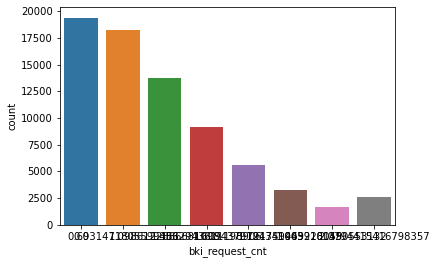

In [34]:
# рассматрим распределение категориальных признаков
for col in cat_cols:
    print('Признак "{a}":'.format(a=col))  # выводим название признака

    # выводим уникальные значения и их количество
    print(data[col][data['train'] == 1].value_counts())

    # выводим распределение заемщиков по признакам
    plt.figure()
    sns.countplot(x=col, data=data[data['train'] == 1])
    plt.show()

У категориальных признаков также наблюдается несбалансированное распределение - один показатель сильно превуалирует над остальными

### Значимость признаков

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   education         110148 non-null  object        
 3   sex               110148 non-null  int32         
 4   age               110148 non-null  float64       
 5   car               110148 non-null  int32         
 6   car_type          110148 non-null  int32         
 7   decline_app_cnt   110148 non-null  int64         
 8   good_work         110148 non-null  int64         
 9   score_bki         110148 non-null  float64       
 10  bki_request_cnt   110148 non-null  float64       
 11  region_rating     110148 non-null  int64         
 12  home_address      110148 non-null  int64         
 13  work_address      110148 non-null  int64         
 14  inco

Так как в признаке education хвранятся объекты, то для начала признак необходимо преобразовать с помощью LabelEncoder

In [36]:
label_encoder = LabelEncoder()
data['education'] = label_encoder.fit_transform(data['education'])

data.education.head()

0    3
1    3
2    3
3    3
4    1
Name: education, dtype: int32

<AxesSubplot:>

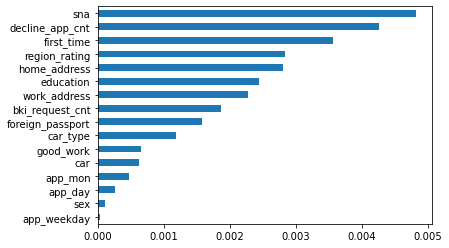

In [37]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Самый важный признак sna, наименее важный признак app_weekday. Исключим его из выборки

In [38]:
cat_cols = [
    'education',
    'region_rating',
    'home_address',
    'work_address',
    'sna',
    'first_time',
    'app_day',
    'app_mon'
]

### Оценка корреляций

<AxesSubplot:>

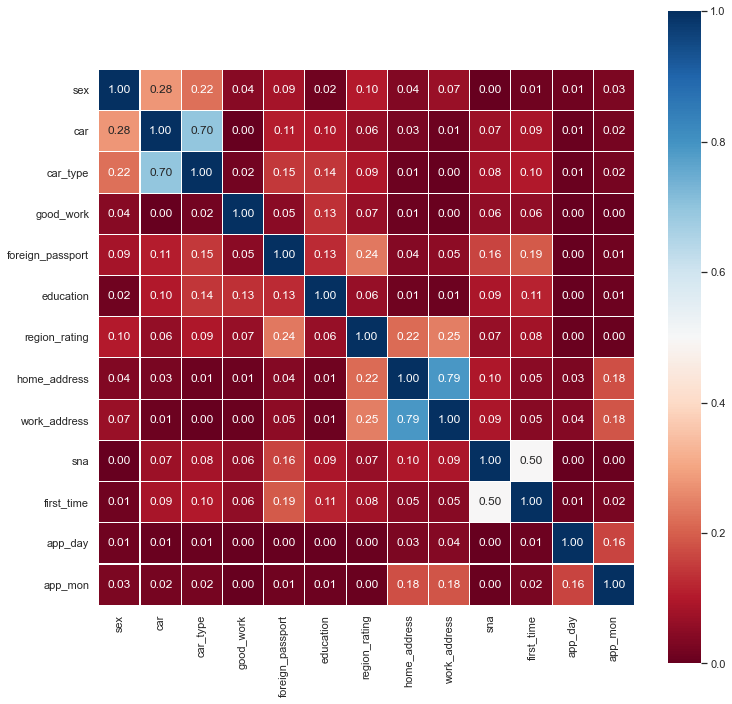

In [39]:
# оценим корреляцию Спирмана для нечисловых признаков
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(data[bin_cols + cat_cols].corr(method='spearman').abs(), vmin=0, vmax=1, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu")

Наибольшая корреляция наблюдаеся у пар признаков: car_type и car; work_adress и home_adress; first_time и sna.
1. По своему значению признаки car_type и car похожи - если у заемщика нет автомобиля, соответственно у него не может и иномарки. Так как признак car_type значительнее, то признак car удалим из модели.
2. Похожая ситуация наблюдается и с признаками work_adress и home_adress - люди, проживающие в благополучном районе маловероятно будут работать в неблагополучном месте, также может для многих людей важно выбирать место проживания, опираясь на местоположение работы. Так как показатель рабочего места ниже чем домашнего то принято решение удалить его из модели.
3. Признаки first_time и sna принято решение оставить без изменений, так как информация зашифрованная в признаках может быть равновероятно пресекаться и не пересекаться

In [40]:
# оставим бинарные и категориальные признаки, которые будут использоваться в модели
# бинарные
bin_cols = ["sex", "car_type", "good_work", "foreign_passport"]

# категориальные
cat_cols = [
    'education',
    'region_rating',
    'home_address',
    'sna',
    'first_time',
    'app_day',
    'app_mon'
]

## Подготовка данных к машинному обучению

In [41]:
# выделяем тренировочный датасет из датасета data
data_train = data[data['train'] == 1]
data_train = data_train.drop(['client_id', 'app_date', 'train'], axis=1)

In [42]:
data_train.info()  # проверяем размер датасета

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   education         73799 non-null  int32  
 1   sex               73799 non-null  int32  
 2   age               73799 non-null  float64
 3   car               73799 non-null  int32  
 4   car_type          73799 non-null  int32  
 5   decline_app_cnt   73799 non-null  int64  
 6   good_work         73799 non-null  int64  
 7   score_bki         73799 non-null  float64
 8   bki_request_cnt   73799 non-null  float64
 9   region_rating     73799 non-null  int64  
 10  home_address      73799 non-null  int64  
 11  work_address      73799 non-null  int64  
 12  income            73799 non-null  float64
 13  sna               73799 non-null  int64  
 14  first_time        73799 non-null  int64  
 15  foreign_passport  73799 non-null  int32  
 16  default           73799 non-null  int64 

In [43]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(data_train[num_cols].values)
X_num.shape  # проверяем размер датасета

(73799, 3)

In [44]:
# преобразуем категориальные признаки методом One-Hot Encoding
X_cat = OneHotEncoder(sparse=False).fit_transform(data_train[cat_cols].values)
X_cat.shape  # проверяем размер датасета

(73799, 58)

In [45]:
# Объединяем все признаки в одно пространство

X = np.hstack([X_num, data_train[bin_cols].values, X_cat])
y = data_train['default'].values

## Построение наивной модели

In [46]:
# Разобьем данные для обучения и тестирования
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [47]:
# Обучаем модель на стандартных настройках логистической регресии
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Оценка качества модели

<AxesSubplot:>

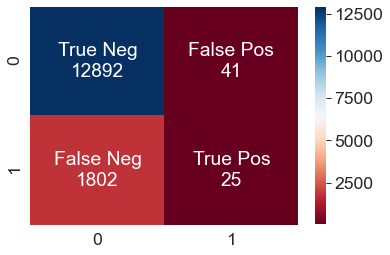

In [48]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=labels, fmt='', cmap='RdBu')

Полученная модель плохо предсказывает заемщиков, которые в будущем могут не выплачить кредиты.

## ROC - анализ

In [49]:
# Вычислим необходимые метрики:
from sklearn.metrics import precision_score, recall_score, f1_score

Y_predicted = model.predict(X_test)
print('Precision score = ', precision_score(y_test, Y_predicted))
print('Recall = ', recall_score(y_test, Y_predicted))
print('F1 = ', f1_score(y_test, Y_predicted))

Precision score =  0.3787878787878788
Recall =  0.013683634373289545
F1 =  0.026413100898045428


In [50]:
# считаем метрики обучающей (X_train, y_train) выборки
probs_train = model.predict_proba(X_train)
probs_train = probs_train[:, 1]
fpr_train, tpr_train, threshol_traind = roc_curve(y_train, probs_train)
roc_auc_train = roc_auc_score(y_train, probs_train)

In [51]:
# считаем метрики обучающей (X_test, y_test) выборки
probs_test = model.predict_proba(X_test)
probs_test = probs_test[:, 1]
fpr_test, tpr_test, threshold_test = roc_curve(y_test, probs_test)
roc_auc_test = roc_auc_score(y_test, probs_test)

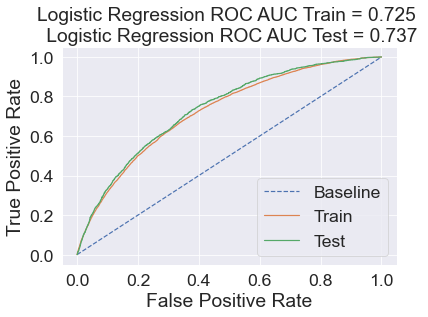

In [52]:
# Рисуем график
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.title('Logistic Regression ROC AUC Train = {a} \n Logistic Regression ROC AUC Test = {b}'
          .format(a=roc_auc_train.round(3), b=roc_auc_test.round(3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Значения различаются не сильно, переобучения нет. Посмотрим, можно ли найти более оптимальные параметры для модели.

# Гиперпараметры

In [53]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']},
    {'penalty': ['none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']}
]

# Создаем сетку поиска
clf = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)

clf.fit(X_train, y_train)
model = clf.best_estimator_

# View best hyperparameters
best_parameters = model.get_params()
for param_name in best_parameters:
    print(param_name, best_parameters[param_name], '\n')

C 1.0 

class_weight balanced 

dual False 

fit_intercept True 

intercept_scaling 1 

l1_ratio None 

max_iter 1000 

multi_class auto 

n_jobs None 

penalty l2 

random_state None 

solver newton-cg 

tol 0.0001 

verbose 0 

warm_start False 



### Строим модель с подобранными гиперпарамметрами

In [54]:
# Разобьем данные для обучения и тестирования по новой
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [55]:
# Обучаем модель на на подобранных гиппер памамметрах
model_hyper = LogisticRegression(C=1,
                           class_weight='balanced',
                           dual=False,
                           fit_intercept=True,
                           intercept_scaling=1,
                           l1_ratio=None,
                           max_iter=1000,
                           multi_class='auto',
                           n_jobs=None,
                           penalty='l2',
                           random_state=None,
                           solver='lbfgs',
                           tol=0.0001,
                           verbose=0,
                           warm_start=False)
model_hyper.fit(X_train, y_train)
y_pred = model_hyper.predict(X_test)

<AxesSubplot:>

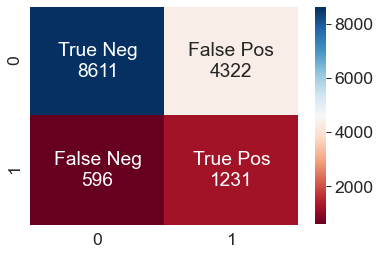

In [56]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=labels, fmt='', cmap='RdBu')

Эта модель гораздо лучше справляется с поставленной задачей

### ROC - анализ

In [57]:
# Вычислим необходимые метрики:
Y_predicted = model_hyper.predict(X_test)
print('Precision score = ', precision_score(y_test, Y_predicted))
print('Recall = ', recall_score(y_test, Y_predicted))
print('F1 = ', f1_score(y_test, Y_predicted))

Precision score =  0.22168197370790563
Recall =  0.6737821565407772
F1 =  0.3336043360433604


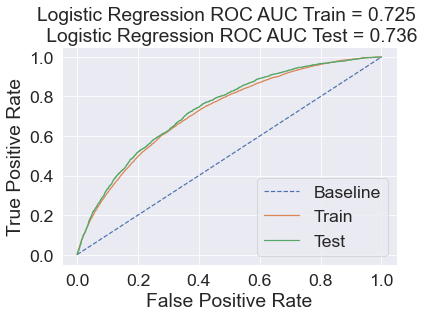

In [58]:
# считаем метрики обучающей (X_train, y_train) выборки
probs_train = model_hyper.predict_proba(X_train)
probs_train = probs_train[:, 1]
fpr_train, tpr_train, threshol_traind = roc_curve(y_train, probs_train)
roc_auc_train = roc_auc_score(y_train, probs_train)

# считаем метрики обучающей (X_test, y_test) выборки
probs_test = model_hyper.predict_proba(X_test)
probs_test = probs_test[:, 1]
fpr_test, tpr_test, threshold_test = roc_curve(y_test, probs_test)
roc_auc_test = roc_auc_score(y_test, probs_test)

# Рисуем график
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.title('Logistic Regression ROC AUC Train = {a} \n Logistic Regression ROC AUC Test = {b}'
          .format(a=roc_auc_train.round(3), b=roc_auc_test.round(3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Расхождение метрики ROC AUC для обучающей и тестовоый выборок не изменилось, однако метрика Precision score снизилась  с 0,375 до 0,221, а метрики Recall и F1 выросли - с 0,011 до 0,682 и с 0,022 до 0,334 соответственно. 
Будем использовать модель с подобранными гиперпараметрами. После обработки датасета и добавления новых признаков была сгенерирована базовая модель логистической регрессии, которая показала ROC AUC > 0.73.
Модель была подстроена с подбором параметров через GridSearchCV. 
Для дальнейшего усовершенствования модели может быть необходимо создать новые признаки или придумать какие-либо решения со значениями, которые вызывают сомнение в рамках IQR.

# Определяем вероятность дефолта клиента банка

In [59]:
# выделяем тестовый датасет из датасета data
data_test = data[data['train'] == 0]
data_test = data_test.drop(['client_id', 'app_date', 'train'], axis=1)

In [60]:
data_test.info()  # проверяем размер датасета

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36349 entries, 73799 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   education         36349 non-null  int32  
 1   sex               36349 non-null  int32  
 2   age               36349 non-null  float64
 3   car               36349 non-null  int32  
 4   car_type          36349 non-null  int32  
 5   decline_app_cnt   36349 non-null  int64  
 6   good_work         36349 non-null  int64  
 7   score_bki         36349 non-null  float64
 8   bki_request_cnt   36349 non-null  float64
 9   region_rating     36349 non-null  int64  
 10  home_address      36349 non-null  int64  
 11  work_address      36349 non-null  int64  
 12  income            36349 non-null  float64
 13  sna               36349 non-null  int64  
 14  first_time        36349 non-null  int64  
 15  foreign_passport  36349 non-null  int32  
 16  default           36349 non-null  i

In [61]:
# Стандартизация числовых переменных
X_num_test = StandardScaler().fit_transform(data_test[num_cols].values)
X_num_test.shape  # проверяем размер датасета

(36349, 3)

In [62]:
# преобразуем категориальные признаки методом One-Hot Encoding
X_cat_test = OneHotEncoder(sparse=False).fit_transform(data_test[cat_cols].values)
X_cat_test.shape  # проверяем размер датасета

(36349, 58)

In [63]:
# Объединяем все признаки в одно пространство
X = np.hstack([X_num_test, data_test[bin_cols].values, X_cat_test])

# делаем расчет
y = model_hyper.predict_proba(X)
y = y[:,1]

In [64]:
# создаем новый датасет
submit = pd.DataFrame(test.client_id)

# включаем в датасет расчитанные значения признака default
submit['default'] = y

# выгружаем получившийся датасет в файл
submit.to_csv('submission.csv', index=False)

submit.sample(5)

,client_id,default
23543,102306,0.746376
18501,21251,0.687462
18788,109591,0.295985
16709,41718,0.372508
24295,69348,0.107279
